<a href="https://colab.research.google.com/github/eswens13/deep_learning/blob/master/cifar_10_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CIFAR-10 Classifier/Autoencoder

This notebook is an exploratory exercise in convolutional neural networks.  I will build a classifier for the CIFAR-10 image set and play around with network architecture, hyperparameters, visualization techniques, etc. to get hands-on experience coding convolutional neural networks in TensorFlow.

I will also explore the differences between a classifier and an auto-encoder.

## Define Network Architecture

First, we have to define a network architecture.  The code in the cell below has comments explaining the architecture of each of the layers.

In [0]:
import tensorflow as tf

def create_model(img_batch, classes):
  """
  Defines the neural network architecture for CIFAR-10 classification.
  
  Parameters:
    - img_batch: A batch of images to classify, as a Tensor object.
                 Shape: (N x 32 x 32 x 3)
    - classes:   The labels for each image, as a Tensor object.
                 Shape: (N, 10)
  """
  [N, H, W, C] = img_batch.get_shape().as_list()
  
  # Convolutional Layer 1:
  #    - Input shape: (N, 32, 32, 3)
  #    - 16 3x3 filters
  #    - Zero-pad input to keep same feature map dimensions
  #    - ReLU activation
  #    - Output shape: (N, 32, 32, 16)
  with tf.variable_scope("conv1") as scope:
    filter_shape_conv1 = (3, 3)
    filters_conv1 = 16
    w_conv1 = tf.get_variable("W", \
                              [filter_shape_conv1[0], \
                                filter_shape_conv1[1], \
                                C, \
                                filters_conv1], \
                              initializer=tf.random_normal_initializer)
    b_conv1 = tf.get_variable("b", \
                              [filters_conv1], \
                              initializer=tf.zeros_initializer)
    strides = [1, 1, 1, 1]
    padding = "SAME"
    
    conv_conv1 = tf.nn.conv2d(img_batch, w_conv1, strides, padding)
    out1 = tf.nn.relu(conv_conv1 + b_conv1, name=scope.name)
  
  # Convolutional Layer 2:
  #    - Input shape: (N, 32, 32, 16)
  #    - 32 3x3 filters
  #    - Lose a pixel off each side because of convolution.
  #    - ReLU activation
  #    - Output shape: (N, 30, 30, 32)
  with tf.variable_scope("conv2") as scope:
    filter_shape_conv2 = (3, 3)
    filters_conv2 = 32
    w_conv2 = tf.get_variable("W", \
                              [filter_shape_conv2[0], \
                                filter_shape_conv2[1], \
                                filters_conv1, \
                                filters_conv2], \
                              initializer=tf.random_normal_initializer)
    b_conv2 = tf.get_variable("b", \
                              [filters_conv2], \
                              initializer=tf.zeros_initializer)
    strides = [1, 1, 1, 1]
    padding = "VALID"
    
    conv_conv2 = tf.nn.conv2d(out1, w_conv2, strides, padding)
    out2 = tf.nn.relu(conv_conv2 + b_conv2, name=scope.name)
  
  # Convolutional Layer 3:
  #    - Input shape: (N, 30, 30, 32)
  #    - 64 5x5 filters
  #    - Lose two pixels off each side because of convolution.
  #    - ReLU activation
  #    - Output shape: (N, 26, 26, 64)
  with tf.variable_scope("conv3") as scope:
    filter_shape_conv3 = (5, 5)
    filters_conv3 = 64
    w_conv3 = tf.get_variable("W", \
                              [filter_shape_conv3[0], \
                                filter_shape_conv3[1], \
                                filters_conv2, \
                                filters_conv3], \
                              initializer=tf.random_normal_initializer)
    b_conv3 = tf.get_variable("b", \
                              [filters_conv3], \
                              initializer=tf.zeros_initializer)
    strides = [1, 1, 1, 1]
    padding = "VALID"
    
    conv_conv3 = tf.nn.conv2d(out2, w_conv3, strides, padding)
    out3 = tf.nn.relu(conv_conv3 + b_conv3, name=scope.name)
  
    # Since this is the last convolutional layer, we need to "flatten" the
    # output into a one dimensional vector (well, really a one-dimensional
    # vector per input image).
    flat_out = tf.reshape(out3, [N, -1])
    neurons_flat = flat_out.get_shape().as_list()[1]
  
  # Dense Layer 1:
  #    - Input shape: (N, (26 * 26 * 64))
  #    - Neurons: 512
  #    - ReLU activation
  #    - Ouput shape: (N, 512)
  with tf.variable_scope("dense1") as scope:
    neurons_dense1 = 512
    w_dense1 = tf.get_variable("W", \
                               [neurons_flat, neurons_dense1], \
                               initializer=tf.random_normal_initializer)
    b_dense1 = tf.get_variable("b", \
                               [neurons_dense1], \
                               initializer=tf.zeros_initializer)
    mul_dense1 = tf.matmul(flat_out, w_dense1)
    out_dense1 = tf.nn.relu(mul_dense1 + b_dense1, name=scope.name)
  
  # Dense Layer 2:
  #    - Input shape: (N, 512)
  #    - Neurons: 128
  #    - ReLU activation
  #    - Ouput shape: (N, 128)
  with tf.variable_scope("dense2") as scope:
    neurons_dense2 = 128
    w_dense2 = tf.get_variable("W", \
                               [neurons_dense1, neurons_dense2], \
                               initializer=tf.random_normal_initializer)
    b_dense2 = tf.get_variable("b", \
                                [neurons_dense2], \
                                initializer=tf.zeros_initializer)
    mul_dense2 = tf.matmul(out_dense1, w_dense2)
    out_dense2 = tf.nn.relu(mul_dense2 + b_dense2, name=scope.name)
    
  with tf.variable_scope("dense3") as scope:
    n_classes = 10
    w_dense3 = tf.get_variable("W", \
                               [neurons_dense2, n_classes], \
                               initializer=tf.random_normal_initializer)
    b_dense3 = tf.get_variable("b", \
                                [n_classes], \
                                initializer=tf.zeros_initializer)
    mul_dense3 = tf.matmul(out_dense2, w_dense3)
    out_dense3 = mul_dense3 + b_dense3
  
  # Softmax layer.
  with tf.variable_scope("softmax") as scope:
    # The reduce_mean takes the mean in a given axis, thereby reducing the
    # the dimensions of the tensor. If no axis is given, it takes the mean of
    # the entire tensor.
    #
    # The softmax_cross_entropy_with_logits_v2 function calculates the softmax
    # cross entropy loss without requiring us to convert the outputs of the last
    # dense layer into probabilities first. (The 'logits' are raw outputs of the
    # aforementioned outputs.)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2( \
                          labels=classes, logits=out_dense3))
  
  return loss

## Training Setup

Now that we've defined a network architecture, we need to set up a training loop to map how the network will be updated.  We need to choose an optimizer and set up backpropagation.

In [0]:
import matplotlib.pyplot as plt

def train_batch(img_batch, labels, optimizer):
  """
  Trains the network (forward pass followed by backpropagation) on a batch of
  images.
  
  Parameters:
    - img_batch: A batch of input images, as a Tensor object.
                 Shape: (N, H, W, C)
    - labels:    The labels for each input image in the batch, as a Tensor.
                 Shape: (N, 10)
    - optimizer: A TF Optimizer object that performs the backpropagation.
  """
  loss = create_model(img_batch, labels)
  opt = optimizer.minimize(loss)
  return loss, opt

Here, we simulate a single batch of data just to verify that forward and backward pass run without issue.

In [50]:
import numpy as np

# Reset the graph so we don't have variable collisions when we re-run.
tf.reset_default_graph()

# Simulate a batch of 32 images (each 32 x 32 pixels RBG)
input_image = np.zeros((32, 32, 32, 3))

# Simulate a batch of labels for the input images.
input_labels = np.zeros((32, 10))
for i in range(input_labels.shape[0]):
  input_labels[i][i % 10] = 1

# Create a placeholder for the input tensor (to be passed to the model).
img = tf.placeholder(tf.float32, shape=input_image.shape)

# Create a placeholder for the corresponding labels.
img_labels = tf.placeholder(tf.float32, shape=input_labels.shape)

# Create an optimizer that will manage the backpropagation.
optimizer = tf.train.AdamOptimizer(learning_rate=1e-3)

# Run a single training loop.
loss, backprop = train_batch(img, img_labels, optimizer)

# Create the TF session and run the graph.
with tf.Session() as sess:
  # Initialize all the variables according to their initializers.
  sess.run(tf.global_variables_initializer())

  # This call starts the chain of operations in the computation graph created
  # above.
  loss_output = sess.run(loss, feed_dict={img: input_image, \
                                          img_labels: input_labels})
  
  opt_output = sess.run(backprop, feed_dict={img: input_image, \
                                             img_labels: input_labels})
  
  print("Output: {}".format(loss_output))

Output: 2.3025851249694824


## Bring in Data

In order to actually train the model, we need to bring in actual data.  Download the CIFAR-10 dataset and get it into a format that we can use.

In [51]:
# I'm cheating and using Keras to import the dataset without having to do a lot
# of processing myself.
from keras.datasets import cifar10
from keras.utils.np_utils import to_categorical

(X_train, y_train), (X_test, y_test) = cifar10.load_data()

# Change the labels to one-hot vectors.
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

# Examine what the data looks like.
print("X_train shape: {}".format(X_train.shape))
print("y_train shape: {}".format(y_train.shape))
print("X_test shape: {}".format(X_test.shape))
print("y_test shape: {}".format(y_test.shape))

X_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 10)
X_test shape: (10000, 32, 32, 3)
y_test shape: (10000, 10)


In [0]:
def training_loop(X, y, num_epochs=10, batch_size=128, learning_rate=1e-3):
  """
  Trains a CNN on the CIFAR-10 dataset.
  
  Parameters:
    - X:             The set of training samples to choose from. 
    - num_epochs:    The number of batches to process.
    - num_samples:   The total number of samples to choose from.
    - batch_size:    The number of samples in a training batch.
    - learning_rate: The learning rate to use during backpropagation.
  """
  num_samples = X.shape[0]
  
  # Reset the graph so we don't have variable collisions when we re-run.
  tf.reset_default_graph()

  # Create a placeholder for the input tensor (to be passed to the model).
  img = tf.placeholder(tf.float32, \
                       shape=(batch_size, X.shape[1], X.shape[2], X.shape[3]))

  # Create a placeholder for the corresponding labels.
  img_labels = tf.placeholder(tf.float32, shape=(batch_size, y.shape[1]))

  # Create an optimizer that will manage the backpropagation.
  optimizer = tf.train.AdamOptimizer(learning_rate=1e-3)

  # Run a single training loop.
  loss, backprop = train_batch(img, img_labels, optimizer)
  
  # Create a vector for the losses from each epoch.
  loss_history = []

  # Create the TF session and run the graph.
  with tf.Session() as sess:
    # Initialize all the variables according to their initializers.
    sess.run(tf.global_variables_initializer())    
  
    for i in range(num_epochs):
      # Randomly select a batch of images from the training set.
      inds = np.random.randint(0, num_samples, batch_size)
      batch = X[inds]
      batch_labels = y[inds]
      
      # Get the loss using the current weights in the graph. This call starts
      # the chain of operations in the computation graph created above.
      epoch_loss = sess.run(loss, feed_dict={img: batch, \
                                             img_labels: batch_labels})
      
      # Run backpropagation on the graph.
      sess.run(backprop, feed_dict={img: batch, img_labels: batch_labels})
      
      # Keep track of the loss.
      loss_history.append(epoch_loss)

  # Plot the loss over the whole training episode.
  font_dict = { 'fontweight' : 'bold' }
  plt.title("Training Loss", fontdict=font_dict)
  plt.plot(loss_history)

## Run Training

Run the training loop for 100 batches of images (happens fairly fast) and investigate the effectiveness of the network.

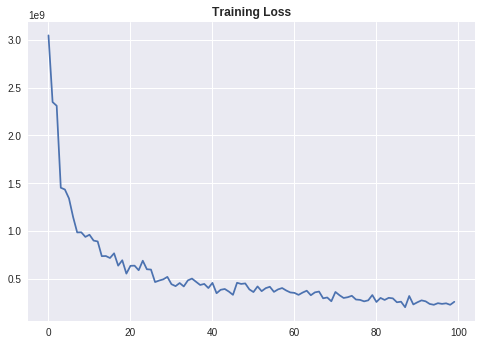

In [53]:
training_loop(X_train, y_train, num_epochs=100)

## Validate the Network

Run the network against the validation data set to evaluate the classification effectiveness.